# System Logs Anomaly Detection using Fine-Tuned LLMs

A fine-tuned LLMs to classify logs as 'normal' or 'anomalous'.

---

## Setup and Imports

In [1]:
!pip install torch transformers huggingface_hub[hf_xet] datasets scikit-learn peft accelerate pandas numpy tqdm seaborn matplotlib nlpaug sentencepiece

Defaulting to user installation because normal site-packages is not writeable


In [31]:
import os
import re
import torch
import pandas as pd
import random as rd
import seaborn as sns
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn.utils import resample
import nlpaug.augmenter.word as naw
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from peft import get_peft_model, LoraConfig, TaskType
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

---

## Data Loading & Preprocessing

#### 1. Load log data

In [3]:
# Ignore warning
pd.set_option('future.no_silent_downcasting', True)

logs_df = pd.read_csv("./data/logs.csv")
labels_df = pd.read_csv("./data/labels.csv")

print(f"Log entries: {len(logs_df)}")

Log entries: 104815


In [4]:
logs_df.head(1)

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>


In [5]:
labels_df.head(1)

,BlockId,Label
0,blk_-1608999687919862906,Normal


---

#### 2. Merge logs & labels datasets

In [6]:
# Extract blockId from content for merging
logs_df["BlockId"] = logs_df["Content"].str.extract(r'(blk_-?\d+)')
# Merge dataset into one
logs_df = pd.merge(logs_df, labels_df, on="BlockId")
# Map 'Normal' to '1' & 'Anomaly' to '0'
logs_df["Label"] = logs_df["Label"].replace({'Normal': 0, 'Anomaly': 1})

In [7]:
logs_df.head(1)

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate,BlockId,Label
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>,blk_-1608999687919862906,0


#### 3. Normalisation

In [8]:
# Different possible dynamic fields in a log entry
patterns = [
    r'True',
    r'true',
    r'False',
    r'false',
    r'\b(zero|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred|thousand|million|billion)\b',
    r'\b(Mon|Monday|Tue|Tuesday|Wed|Wednesday|Thu|Thursday|Fri|Friday|Sat|Saturday|Sun|Sunday)\b',
    r'\b(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+(\d{1,2})\s+\b',
    r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}(:\d{1,5})?',
    r'([0-9A-Fa-f]{2}:){11}[0-9A-Fa-f]{2}',
    r'([0-9A-Fa-f]{2}:){5}[0-9A-Fa-f]{2}',
    r'[a-zA-Z0-9]*[:\.]*([/\\]+[^/\\\s\[\]]+)+[/\\]*',
    r'\b[0-9a-fA-F]{8}\b',
    r'\b[0-9a-fA-F]{10}\b',
    r'(\w+[\w\.]*)@(\w+[\w\.]*)\-(\w+[\w\.]*)',
    r'(\w+[\w\.]*)@(\w+[\w\.]*)',
    r'[a-zA-Z\.\:\-\_]*\d[a-zA-Z0-9\.\:\-\_]*',
]
combined_pattern = '|'.join(patterns)

# helper function to replace dynamic fields with <*>
def replace_dynamic_fields(log):
    log = re.sub(r'[\.]{3,}', '.. ', log)
    log = re.sub(combined_pattern, '<*>', log)
    return log

In [9]:
# Replace dynamic fileds
logs_df['processed_content'] = logs_df['Content'].apply(replace_dynamic_fields)
# Rename column name
logs_df = logs_df.rename(columns={'Label': 'label'})
# Only needed
logs_df = logs_df[['processed_content', 'label']]

In [10]:
logs_df.head()

,processed_content,label
0,Receiving block <*> src: <*> dest: <*>,0
1,BLOCK* NameSystem.allocateBlock: <*> <*>,0
2,Receiving block <*> src: <*> dest: <*>,0
3,Receiving block <*> src: <*> dest: <*>,0
4,PacketResponder <*> for block <*> terminating,0


#### 4. Data Distribution (before 'balancing')


label
0    101544
1      3271
Name: count, dtype: int64



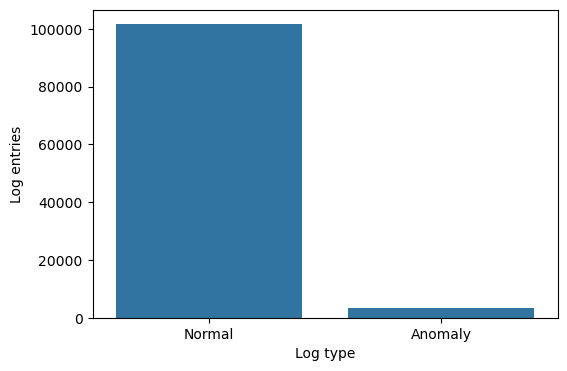


Anomaly: 3.12%



In [11]:
# utility function to calculate the data distribution
def plot_data_distribution(df):
    # Count the labels
    labels_count = df['label'].value_counts()
    print(f"\n{labels_count}\n")
    
    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x=labels_count.index, y=labels_count.values)
    plt.xticks([0, 1], ['Normal', 'Anomaly'])
    plt.ylabel("Log entries")
    plt.xlabel("Log type")
    plt.show()
    
    anomaly = labels_count[1] / sum(labels_count) * 100
    print(f"\nAnomaly: {anomaly:.2f}%\n")

plot_data_distribution(logs_df)

Here, the data is highly imbalanced

#### 5. Balance Dataset

In [12]:
# split the datasets
normal_df = logs_df[logs_df['label'] == 0]
anomaly_df = logs_df[logs_df['label'] == 1]

In [13]:
# utilty function to augment anomalies by swapping or deleting words 
def augment_anomalies(log, max_changes=1):
    aug = rd.choice([
        naw.RandomWordAug(action="swap"), 
        naw.RandomWordAug(action="delete")
    ])
    augmented = aug.augment(log, n=max_changes)
    return augmented[0] if isinstance(augmented, list) else augmented

# augment
new_anomaly_df = anomaly_df.copy()
new_anomaly_df['processed_content'] = new_anomaly_df['processed_content'].apply(lambda txt: augment_anomalies(txt, 2))

# combine both original & new anomalies
combined_anomaly_df = pd.concat([anomaly_df, new_anomaly_df])

# resample the new anomalies to match normal log entries
balanced_df = resample(combined_anomaly_df, replace=True, n_samples=len(normal_df), random_state=42)

# balanced dataset
new_log_df = pd.concat([normal_df, balanced_df])
new_log_df = new_log_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
new_log_df.head(5)

,processed_content,label
0,Receiving block <*> src: <*> dest: <*>,0
1,Receiving block <*> src: <*> dest: <*>,0
2,Block <*> <*> <* >,1
3,BLOCK* NameSystem.addStoredBlock: blockMap upd...,1
4,Received block <*> of size <*> from <*>,0


#### 6. Data Distribution (after 'balancing')


label
0    101544
1    101544
Name: count, dtype: int64



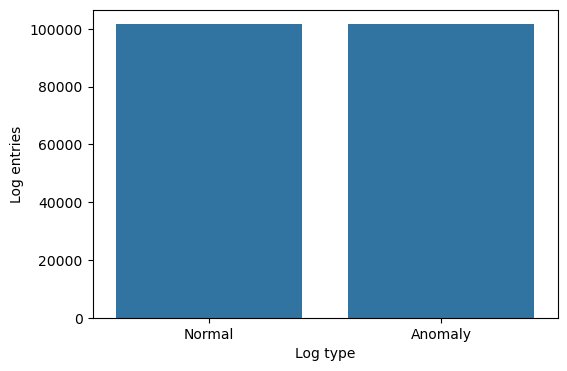


Anomaly: 50.00%



In [15]:
plot_data_distribution(new_log_df)

#### 7. Split dataset: Training & Test

In [16]:
train_df, test_df = train_test_split(
    new_log_df,
    test_size=0.2,
    random_state=42,
    stratify=new_log_df["label"]
)

print(f"Training Split: {len(train_df)} | Test Split: {len(test_df)}")

Training Split: 162470 | Test Split: 40618


---

## Model Training

#### 1. Initialise the model
We are using 'deberta-v3-large' model

In [19]:
# Since we are usign heavy model, lora is added for computational efficiency
lora_config = LoraConfig(
    r=16, 
    lora_alpha=32,
    target_modules=["query_proj", "value_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

In [20]:
# Initiailise model
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-large")
model = DebertaV2ForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-large",
    num_labels=2,
    problem_type="single_label_classification"
)
# wrap with lora
model = get_peft_model(model, lora_config).to('cuda')

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 2. Prepare custom dataset
For creating tokens of log entries for taining transformer models

In [21]:
class LogDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.encodings = tokenizer(
            texts.tolist(),
            truncation=True,
            max_length=max_length,
            padding="max_length"
        )
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

#### 3. Split dataset: Training & Test

In [22]:
train_df, test_df = train_test_split(new_log_df, test_size=0.2)
training_dataset = LogDataset(train_df['processed_content'], train_df['label'], tokenizer)
testing_dataset = LogDataset(test_df['processed_content'], test_df['label'], tokenizer)

#### 4. Train the model

In [23]:
# utility function to calculate the model metrics
def calc_model_metrics(p):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
            "accuracy": accuracy, 
            "precision": precision,
            "recall": recall,
            "f1": f1
           }

In [24]:
# define training arguments
training_args = TrainingArguments(
    output_dir="./output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    fp16=True,
    report_to="none"
)

# train model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_dataset,
    eval_dataset=testing_dataset,
    compute_metrics=calc_model_metrics
)
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.417400,0.446810,0.780935,0.996251,0.563384,0.719748
2,0.468000,0.445155,0.780935,0.996251,0.563384,0.719748
3,0.447300,0.445548,0.780935,0.996251,0.563384,0.719748


TrainOutput(global_step=60927, training_loss=0.44988607254815965, metrics={'train_runtime': 17320.9984, 'train_samples_per_second': 28.14, 'train_steps_per_second': 3.518, 'total_flos': 2.2829694404622336e+17, 'train_loss': 0.44988607254815965, 'epoch': 3.0})

#### 5. Save the model

In [25]:
trainer.save_model("./log_anomaly_model")
tokenizer.save_pretrained("./log_anomaly_model")

('./log_anomaly_model/tokenizer_config.json',
 './log_anomaly_model/special_tokens_map.json',
 './log_anomaly_model/spm.model',
 './log_anomaly_model/added_tokens.json')

---

## Model Evaluation

#### 1. Evalute againt test dataset

In [26]:
test_result = trainer.evaluate(testing_dataset)
print(test_result)

{'eval_loss': 0.44680967926979065, 'eval_accuracy': 0.7809345610320547, 'eval_precision': 0.9962507629261488, 'eval_recall': 0.5633844484985947, 'eval_f1': 0.719748031496063, 'eval_runtime': 533.6199, 'eval_samples_per_second': 76.118, 'eval_steps_per_second': 9.516, 'epoch': 3.0}


#### 2. Classification report

In [33]:
# calculate predictions
test_prediction = trainer.predict(testing_dataset)

prediction_label = test_prediction.predictions.argmax(-1)
true_labels = testing_dataset.labels

# render classification metrics
print(classification_report(true_labels, prediction_label, target_names=["Normal", "Anomaly"]))

              precision    recall  f1-score   support

      Normal       0.70      1.00      0.82     20337
     Anomaly       1.00      0.56      0.72     20281

    accuracy                           0.78     40618
   macro avg       0.85      0.78      0.77     40618
weighted avg       0.85      0.78      0.77     40618



#### 3. Confusion Matrix

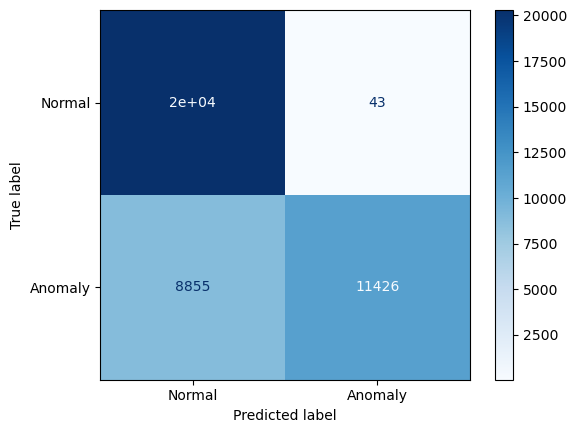

In [35]:
cm = confusion_matrix(true_labels, prediction_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Blues")
plt.show()

#### 4. ROC & AOC Curve

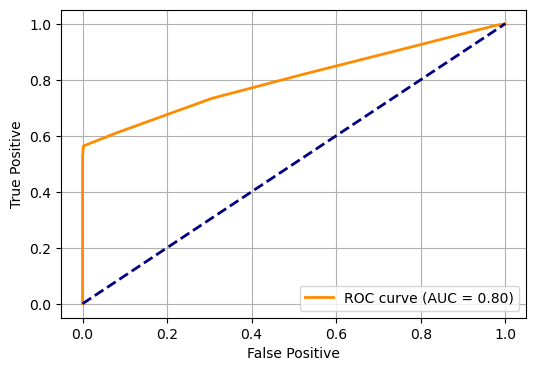

In [38]:
# probabilities for anomalous logs
probs = test_prediction.predictions[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc = roc_auc_score(true_labels, probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

---